# Research Computing Final Project: Investigating trends in the tropical Pacific zonal gradient in CMIP6 models and observations

## Hannah Byrne | hb2731

### Description:

This project aims to quantify and create visualisations of the linear trends in the Pacific equatorial zonal sea surface temperature gradients. Here, the definition of the gradient is per Seager et al., 2022: the area-weighted average sea surface temperature anomaly in a western Pacific box minus that in an eastern Pacific box. The limits of these boxes are as follows:  

East: lat: -3 to 3; lon: 190 to 270  
West: lat: -3 to 3; lon: 140 to 170  

### Code structure

#### 1) Selecting files from openDAP files
Here, we are able to select files based on specific attributes (e.g., name, grid type, variable, scenario ID). The output from this step is a list of URLs for historical model runs, and one for scenario ssp 245 model runs.  

#### 2) Classifying historical and scenario models
This section sorts the files depending on specific requirements for the historical and scnenario inputs as described below.  

##### Classifying historical models:  
Models are stored under the "Full" key if they span the full period specified in the function (i.e., 185001-201412); otherwise models are classified into subdictionaries with the other incomplete time periods.

##### Classifying scenario models:  
Models are checked to make sure that they span the full period in question; they are also checked to see if they are seeded from the same historical parent as the variant label suggests. 

Quick note on the scenario dictionary: the keys for each of the entries in the resultant dictionary is a combination of the model (e.g., MIROC6) and the parent variant run (e.g., r4i1p5f1)  This is because there are some instances within CMIP6 models in which multiple scenario projections are seeded from the same historical parent (i.e., we can't assume that the variant identifier code actually necessarily corresponds between scenario runs and historical runs). This means that there are some instances in the dictionary in which there are multiple URLs under one key.

#### 3) Calculating and storing gradients and trends
The first step here depends on how historical models were classified (Full or not). For historical models that don't span the full period specific, individual files that comprise part of the full period are all concatenated to create files that span the full time range specified for CMIP6 historical ensemble members (1850-2014). Then, historical and scenario ensemble members are matched and joined to extend the model period for the full range covered by the study (1870 - 2024). In some cases, there is direct matching (in which the scenario ensemble member was seeded from the end of a specific historical ensemble member); in other cases, there isn't a 1:1 match and so historical and scenario ensemble members are randomly paired.  

The climatology is removed to create a sea surface temperature anomaly dataset. From here, the area-weighted gradients are calculated for each ensemble member. Based on this gradient time series, the linear trend for every start and end date in the study period is calculated.  

Gradient timeseries and trend dataframes are saved because calculating these quanitities is computationally intensive and takes a long time.  

#### 4) Plotting the calculated gradients and trends
The outputs that were saved in the previous step are read back in (so that this code does not need to be run from the beginning every time).  

Plots were created showing:  
The multi model mean (forced response) and range for each model  
Individual plots showing trends, as well as the multi model mean trend


## Setting up the environment

In [1]:
%load_ext autoreload

In [2]:
%reload_ext autoreload
%autoreload 2

### Libraries and packages

In [3]:
# analysis functions
import numpy as np
import xarray as xr
import pandas as pd

# systems functions
import os
from collections import defaultdict

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# my own functions
from FP_functions import ClassifyHistModelsLite, CreateScenarioDictionary, MakeChangeDir, ExtendPeriod, RemoveClimatology, ConcatModels
from FP_classes import ModelInput, Trend, Gradient

### Directories and files

#### Outputs

In [4]:
# trends and gradients
pathBase = '/home/hb2731/assignments/FP_outputs/'
trendsDirEnd = 'Trends'
gradientsDirEnd = 'Gradients'

trendsDir = pathBase + trendsDirEnd
gradientsDir = pathBase + gradientsDirEnd

# plots
plotsDirEnd = 'Plots'

plotsDir = pathBase + plotsDirEnd

# stats
statsDirEnd = 'Statistics'

statsDir = pathBase + statsDirEnd

#### Inputs

In [5]:
# openDap file
openDapDir = '/home/hb2731/assignments/FP_inputs'

## 1) Selecting files from the openDap

In [6]:
# inputting from a csv file

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(openDapDir)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
# models = ['MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1', 'MPI-ESM1-2-LR', 'CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
models = ['GISS-E2-1-G', 'MPI-ESM1-2-LR']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

## 2) Classifying historical and scenario models

In [7]:
# classifying historical and scenario models depending on the length of time that they cover (i.e., grouping them based on whether they will need to be concatenated with other files)
histModels = ClassifyHistModelsLite(modelListHist)
scenarioModels = CreateScenarioDictionary(modelListScenario)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/sw/anaconda3/2023.09/envs/pangeo23/share/proj failed


Scenario dictionary complete: 1 / 199
Scenario dictionary complete: 2 / 199
Scenario dictionary complete: 3 / 199
Scenario dictionary complete: 4 / 199
Scenario dictionary complete: 5 / 199
Scenario dictionary complete: 6 / 199
Scenario dictionary complete: 7 / 199
Scenario dictionary complete: 8 / 199
Scenario dictionary complete: 9 / 199
Scenario dictionary complete: 10 / 199
Scenario dictionary complete: 11 / 199
Scenario dictionary complete: 12 / 199
Scenario dictionary complete: 13 / 199
Scenario dictionary complete: 14 / 199
Scenario dictionary complete: 15 / 199
Scenario dictionary complete: 16 / 199
Scenario dictionary complete: 17 / 199
Scenario dictionary complete: 18 / 199
Scenario dictionary complete: 19 / 199
Scenario dictionary complete: 20 / 199
Scenario dictionary complete: 21 / 199
Scenario dictionary complete: 22 / 199
Scenario dictionary complete: 23 / 199
Scenario dictionary complete: 24 / 199
Scenario dictionary complete: 25 / 199
Scenario dictionary complete: 26 /

## 3) Calculating and storing the gradients and trends

In [10]:
# creating dictionaries to store the output

trendsDfDict = {} # dictionary that holds the dataframes that the trends are also stored in
gradDict = {} # dictionary to hold the gradient timeseries that are calculated for each ensemble member

counter = 0 # initialising counter so that we can track progress while this runs
modelCount = len(histModels.keys()) # knowing the total number of models to run; again for tracking progress

for key in histModels:

    if key == 'Full':
        for models in histModels[key]:

            # loading and cleaning the data
            modelInput = ModelInput(model)

            # extending the model period through adding in scenarios
            modelIdentifier = modelInput.ds.attrs['source_id'] + '_' + modelInput.ds.attrs['variant_label']
            modelFullPeriod = ExtendPeriod(modelIdentifier, modelInput, scenarioModels)
            
            # remove the climatology from the full dataset
            modelFullPeriod = RemoveClimatology(modelFullPeriod)

            # calculating the gradient and the trends; creating dict with all trends labelled with model name
            gradient = Gradient(modelFullPeriod)
            gradDict[gradient.modelName] = gradient.gradient
            trend = Trend(gradient, 20)
            trendsDfDict[gradient.modelName] = trend.trendsDf
            
            # saving the output to a folder
            MakeChangeDir(trendsDir)
            fileName = modelIdentifier + '_trends.csv'
            trend.trendsDf.to_csv(fileName, index = True)
            
            MakeChangeDir(gradientsDir)
            pathName = gradientsDir + '/' + modelIdentifier + '.nc'
            gradient.gradient.to_netcdf(pathName)

    else:

        # concatenating to the length of the initial period
        model = ConcatModels(histModels[key])

        # loading and cleaning the data
        modelInput = ModelInput(model)

        # extending the model period by adding in scenarios
        modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)

        # removing the climatology from the full dataset
        modelFullPeriod = RemoveClimatology(modelFullPeriod)

        # calculating the gradient and trends; saving these into dictionaries
        gradient = Gradient(modelFullPeriod)
        gradDict[gradient.modelName] = gradient.gradient
        trend = Trend(gradient, 20)
        trendsDfDict[gradient.modelName] = trend.trendsDf

        # saving the output
        MakeChangeDir(trendsDir)
        fileName = key + '_trends.csv'
        trend.trendsDf.to_csv(fileName, index = True)

        MakeChangeDir(gradientsDir)
        pathName = gradientsDir + '/' + key + '.nc'
        gradient.gradient.to_netcdf(pathName)

    counter += 1
    print(f'{counter} / {modelCount}')

1 / 77
2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
77 / 77


## 4) Plotting the calculated gradients and trends

#### First plotting gradient time series

Note that I am plotting for the full time period and a shorter time period just to get a closer look at how it varies on shorter time scales; choice of start and end date for the shorter time period were random and chosen only to illustrate this.

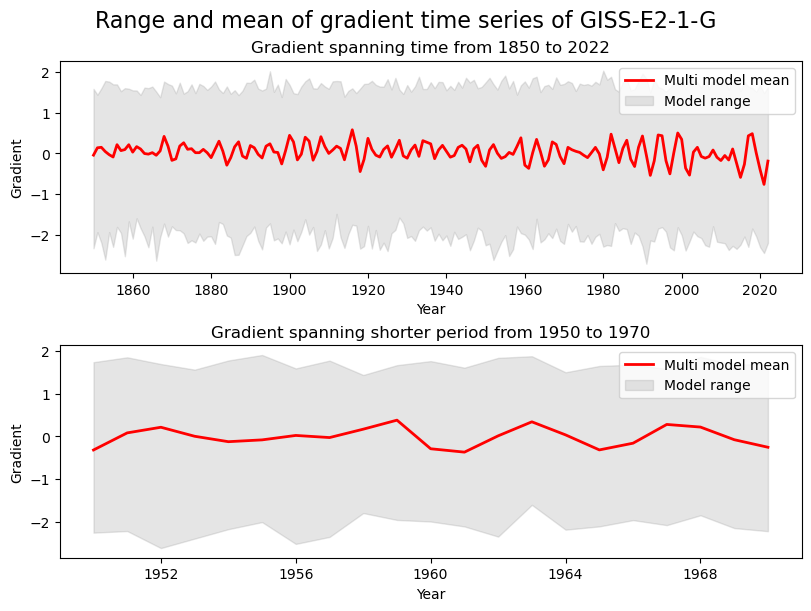

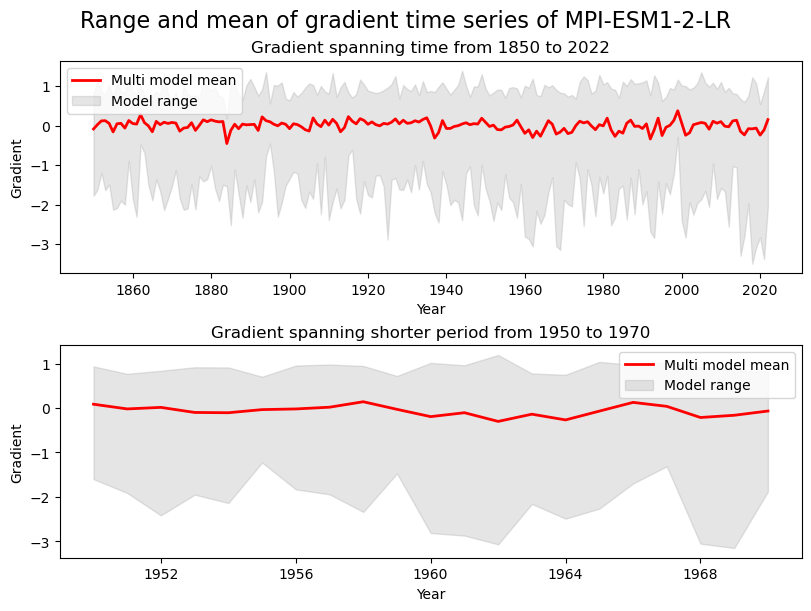

In [17]:
# one plot for each model in the model list; would like this one to show the mean gradient and the spread around this

# selecting an interval for a more zoomed in look at the gradient and spread
intStart = '1950'
intEnd = '1970'

os.chdir(gradientsDir)

for model in models:

    # create list of the files that are for this model
    gradientFiles = os.listdir(gradientsDir)
    gradientFiles = [f for f in gradientFiles if '.nc' in f and model in f] # checking that the files are the right format and are only for the model in question

    # create a concatenated gradient object
    gradientConcat = xr.open_dataset(gradientFiles[0]).sel(time = slice('1850', '2022')) # starting with the first file

    # now iterate through the files and plot them and save to a concatenated version so that the mean can be calculated
    #fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (8, 6), constrained_layout = True)
    #fig.suptitle(f'Gradient time series for {model} including multi model mean', fontsize = 16)

    for index, file in enumerate(gradientFiles):
        gradient = xr.open_dataset(file).sel(time = slice('1850', '2022'))
        
        gradientConcat = xr.concat([gradientConcat, gradient], dim = 'gradient')
    
    # calculating the multi model mean
    gradientMean = gradientConcat.mean(dim = 'gradient')
    #gradientMean.ts.resample(time = 'YS').mean().plot(ax = axes[0], linewidth = 2, label = 'Multi model mean', color = 'red')
    #gradientMean.ts.resample(time = 'YS').mean().sel(time = slice(intStart, intEnd)).plot(ax = axes[1], linewidth = 1, label = 'Multi model mean')

    # setting titles
    #axes[0].set_title(f'Gradient spanning time from 1850 to 2022')
    #axes[0].set_ylabel('Gradient')
    #axes[0].set_xlabel('Year')

    #axes[1].set_title(f'Gradient spanning shorter period from {intStart} to {intEnd}')
    #axes[1].set_ylabel('Gradient')
    #axes[1].set_xlabel('Year')

    # plotting the legend
    #axes[0].legend()
    #axes[1].legend()

    # now creating a second plot that fills in the area between the max and min
    fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (8,6), constrained_layout = True)
    fig.suptitle(f'Range and mean of gradient time series of {model}', fontsize = 16)

    gradientMax = gradientConcat.resample(time = 'YS').mean().max(dim = 'gradient') # calculating the max gradient at every time point; will do the same for min
    gradientMin = gradientConcat.resample(time = 'YS').mean().min(dim = 'gradient')

    gradientMean.ts.resample(time = 'YS').mean().plot(ax = axes[0], label = 'Multi model mean', color = 'red', linewidth = 2)
    axes[0].fill_between(gradientMax.time, gradientMin.ts, gradientMax.ts, color = 'gray', alpha = 0.2, label = 'Model range')

    gradientMean.ts.resample(time = 'YS').mean().sel(time = slice(intStart, intEnd)).plot(ax = axes[1], label = 'Multi model mean', color = 'red', linewidth = 2)
    axes[1].fill_between(gradientMax.time.sel(time = slice(intStart, intEnd)), gradientMin.ts.sel(time = slice(intStart, intEnd)), gradientMax.ts.sel(time = slice(intStart, intEnd)), color = 'gray', alpha = 0.2, label = 'Model range')

    axes[0].set_title(f'Gradient spanning time from 1850 to 2022')
    axes[0].set_ylabel('Gradient')
    axes[0].set_xlabel('Year')

    axes[1].set_title(f'Gradient spanning shorter period from {intStart} to {intEnd}')
    axes[1].set_ylabel('Gradient')
    axes[1].set_xlabel('Year')

    # plotting the legend
    axes[0].legend()
    axes[1].legend()

#### Plotting heatmaps showing the trends

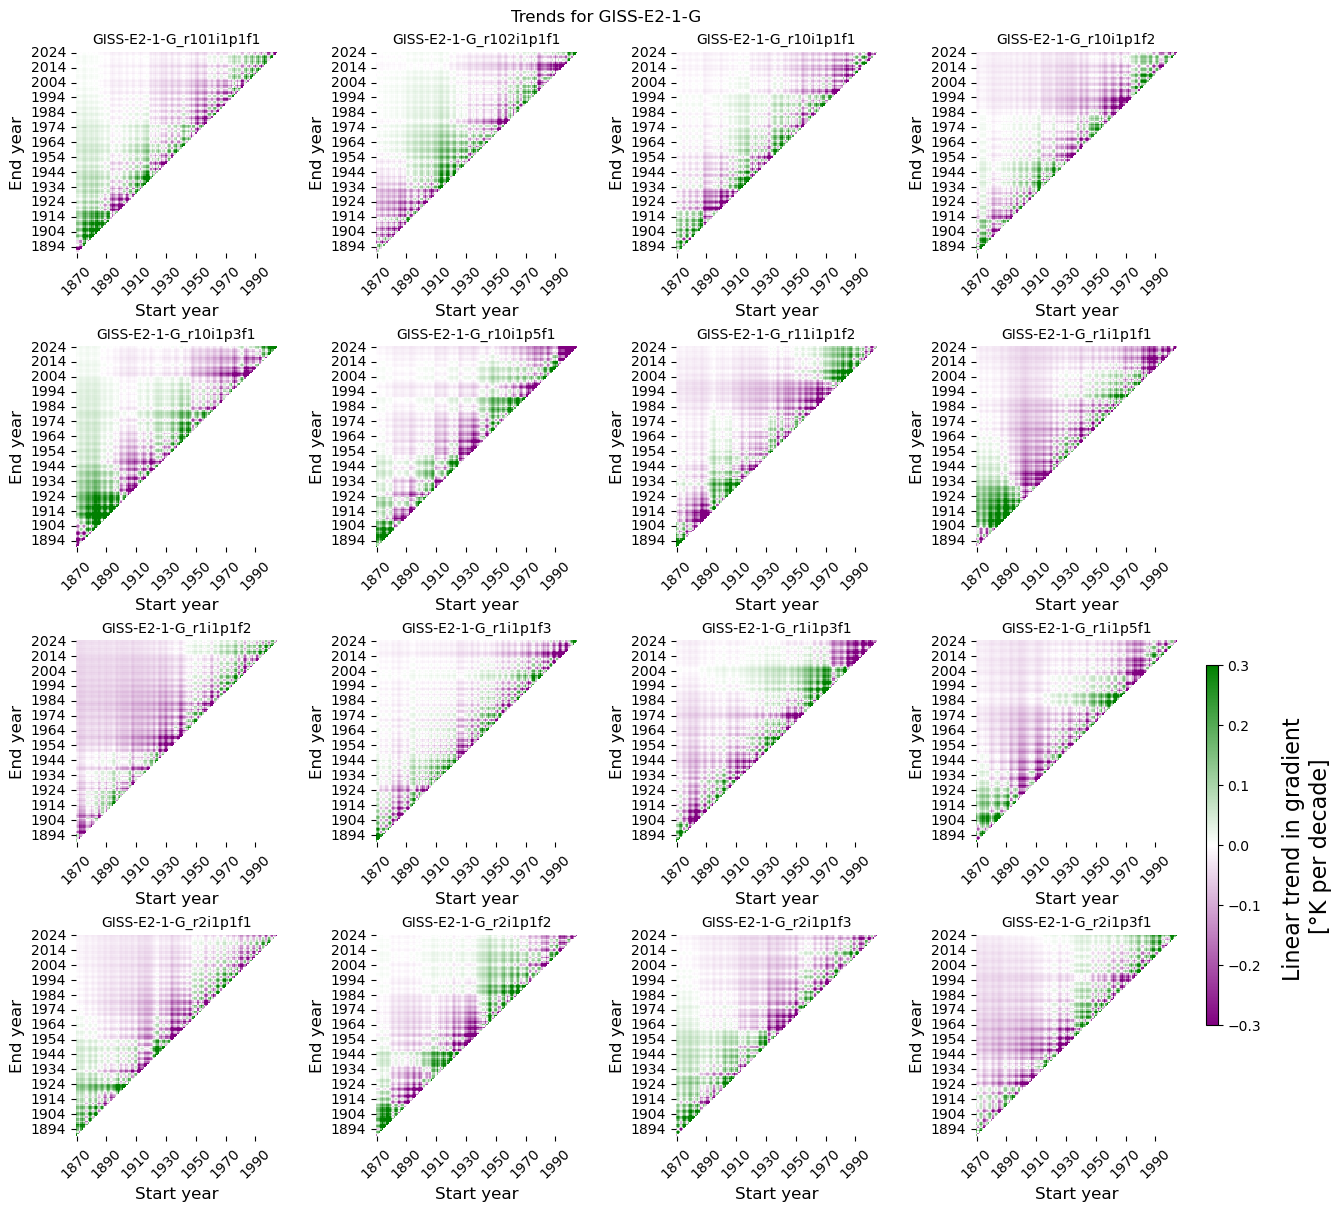

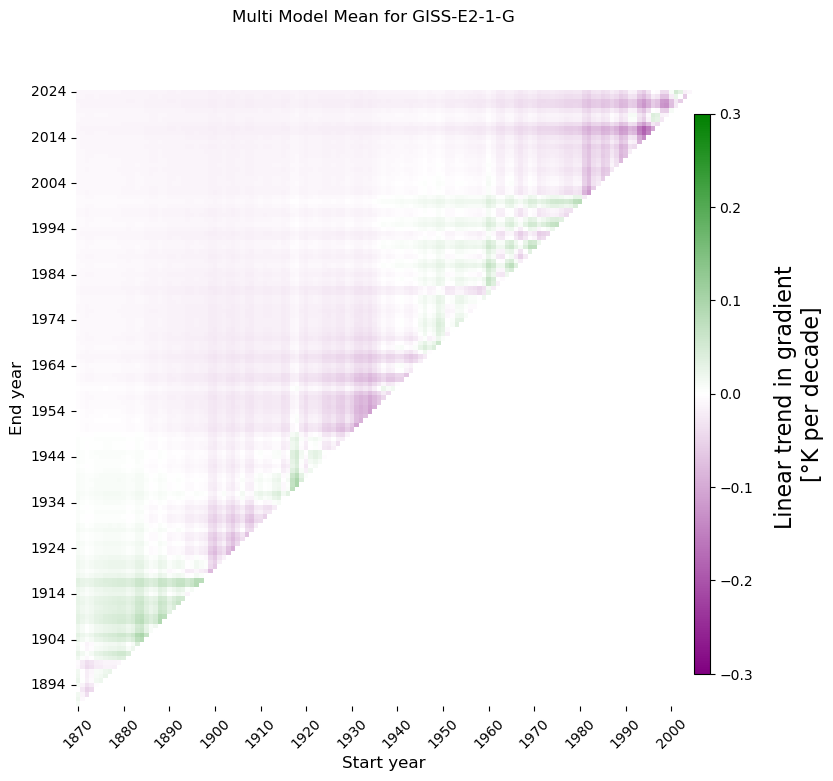

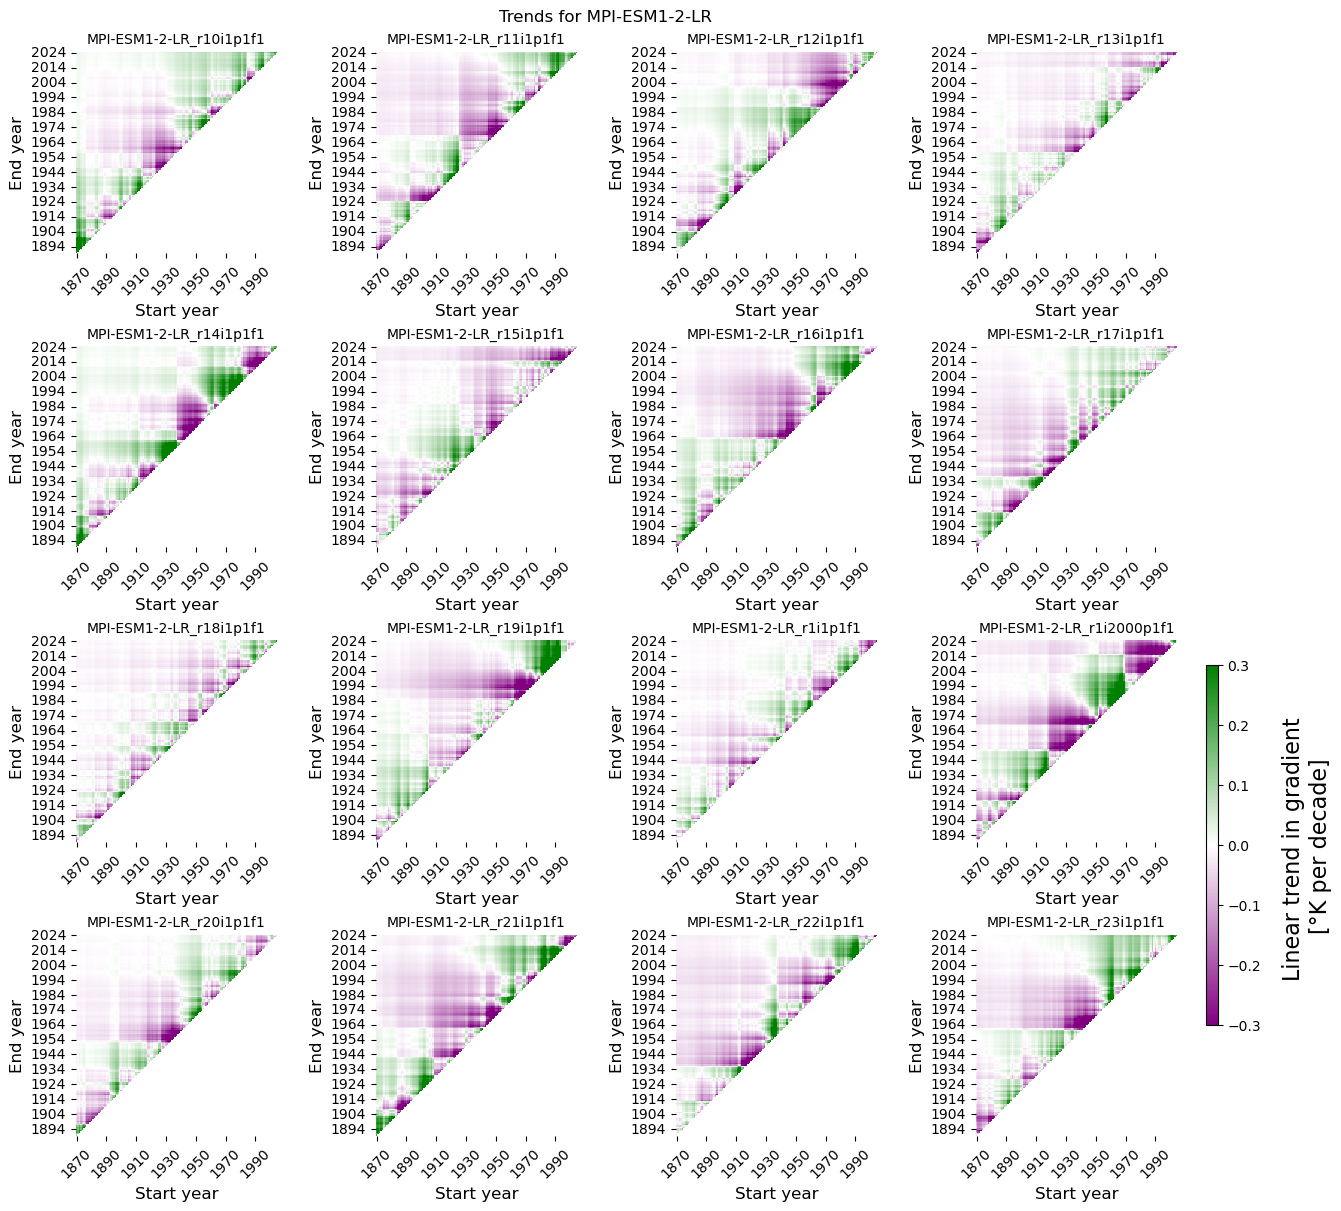

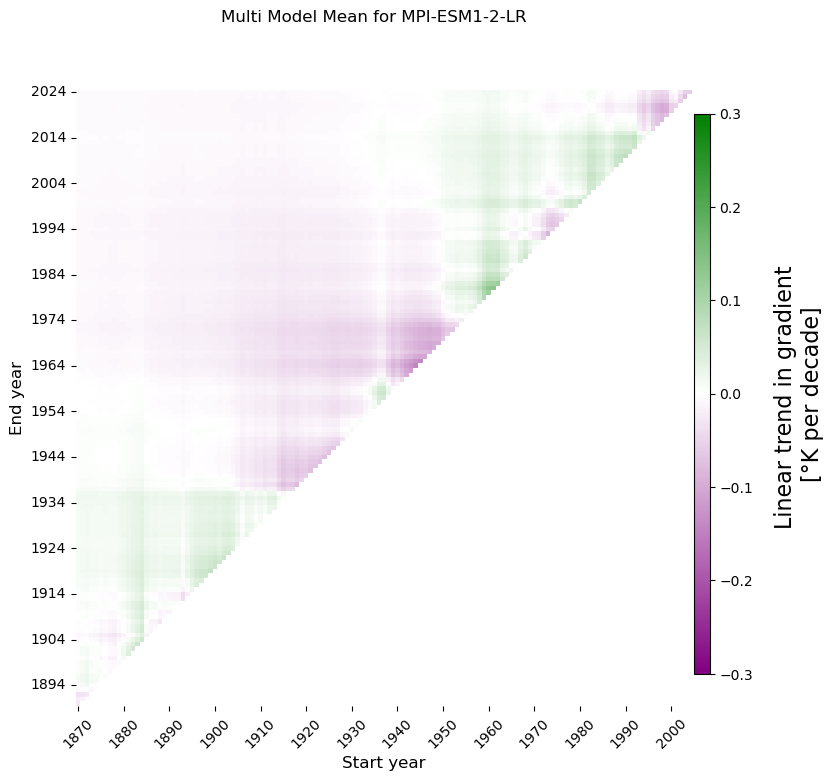

In [12]:
# first plotting specific trend heatmaps and then a mean
os.chdir(trendsDir)

nFigures = 16 # this can be changed depending on how many individual heatmaps are being chosen for viewing

# setting up plotting parameters for subplots
nCols = 4

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (3, 3)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

# setting the colorbar
vmin = -0.3
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# now iterating through models to plot this output
for model in models:
    
    # creating the first figure
    fig, axes = plt.subplots(ncols = nCols, nrows = nRows, figsize = (figWidth, figHeight), constrained_layout = True)
    fig.suptitle(f'Trends for {model}')
    axesFlat = axes.flatten()
    
    # reading in the files
    trendsFiles = os.listdir(trendsDir)
    trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and model in trendsFile]
    modelNames = [name[:name.index('.') - 7] for name in trendsFiles if '.csv' in name and model in name]
    trendsDfMean = sum(trendsDfs) / len(trendsDfs)

    # plotting each dataframe for the number of dataframes selected
    for i in np.arange(nFigures):
        axesFlat[i].set_aspect('equal')
        axesFlat[i].set_title(f'{modelNames[i]}', fontsize = 10)
        plot = sns.heatmap(trendsDfs[i], cmap = cmap, ax = axesFlat[i], vmin = vmin, vmax = vmax, xticklabels = 20, yticklabels = 10, center = 0, cbar = False, norm = norm)
        axesFlat[i].tick_params(axis = 'x', rotation = 45)
        axesFlat[i].tick_params(axis = 'y', rotation = 0)
        axesFlat[i].set_ylabel('End year', fontsize = 12)
        axesFlat[i].set_xlabel('Start year', fontsize = 12)

    cbarAx = fig.add_axes([1, 0.15, 0.01, 0.3])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

    # now plotting the mean for this model
    fig, axes = plt.subplots(figsize = (8,8))
    fig.suptitle(f'Multi Model Mean for {model}')

    axes.set_aspect('equal')
    plot = sns.heatmap(trendsDfMean, cmap = cmap, ax = axes, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
    axes.tick_params(axis = 'x', rotation = 45)
    axes.tick_params(axis = 'y', rotation = 0)
    axes.set_ylabel('End year', fontsize = 12)
    axes.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)